In [70]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds
import time

In [71]:
data = tfds.load('rock_paper_scissors')

In [72]:
data

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [73]:
train_ims = np.array([img['image'].numpy()/256 for img in list(data['train'])])
test_ims = np.array([img['image'].numpy()/256 for img in list(data['test'])])

In [74]:
train_ims.shape

(2520, 300, 300, 3)

In [75]:
y_train = []
y_test = []
y_train_ = np.array([i['label'].numpy() for i in list(data['train'])])
y_test_ = np.array([i['label'].numpy() for i in list(data['test'])])
for each in y_train_:
    y_train.append([int(i == each-1) for i in range(3)])
for each in y_test_:
    y_test.append([int(i == each-1) for i in range(3)])

y_train = np.array(y_train)
y_test = np.array(y_test)

In [76]:
generator = keras.Sequential()
discriminator = keras.Sequential()

gen_lay = [layers.Dense(50*50*5, use_bias=0, input_shape=(1000,)),
           layers.LeakyReLU(),
           layers.BatchNormalization(),
           
           layers.Reshape((50, 50, 5)),
           layers.Conv2DTranspose(100, (5, 5), strides=(2, 2), padding='same', use_bias=0),
           layers.BatchNormalization(),
           layers.LeakyReLU(),

           layers.Conv2DTranspose(150, (5, 5), strides=(3, 3), padding='same', use_bias=0),
           layers.BatchNormalization(),
           layers.LeakyReLU(),

           layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=0, activation='tanh')]
for layer in gen_lay: generator.add(layer)
assert generator.output_shape == (None, 300, 300, 3)
                                  
dis_lay = [layers.Conv2D(500, (5, 5), (3, 3), padding = 'same', input_shape=(300, 300, 3)),
           layers.LeakyReLU(),
           layers.Dropout(0.2),
           
           layers.Conv2D(100, (5, 5), (2, 2), padding='same'),
           layers.LeakyReLU(),
           layers.Dropout(0.2),
           
           layers.Conv2D(100, (5, 5), (2, 2), padding='same'),
           layers.LeakyReLU(),
           layers.Dropout(0.2),
           
           layers.Flatten(),
           layers.Dense(3, activation='softmax')]
for layer in dis_lay: discriminator.add(layer)

In [83]:
focal_entropy = tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True)
def gen_loss(real, fake):
    real_loss = focal_entropy(tf.ones_like(real), real)
    fake_loss = focal_entropy(tf.ones_like(fake), fake)
    total = real_loss + fake_loss
    return total

def dis_loss(fake):
    return focal_entropy(tf.ones_like(fake), fake)

opt_g = tf.keras.optimizers.Adam(1e-4)
opt_d = tf.keras.optimizers.Adam(1e-4)
gen_opt = opt_g; dis_opt = opt_d

epochs = 120
noise_dim = 1000
num_examples_to_generate = 16
batch_size = 35
buffer_size = len(train_ims)

seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function()
def train_step(ims):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(ims, training=True)
        fake_output = discriminator(generated_images, training=True)

        gener_loss = gen_loss(real_output, fake_output)
        discr_loss = dis_loss(fake_output)
    
    gradients_gen = gen_tape.gradient(gener_loss, generator.trainable_variables)
    gradients_disc = dis_tape.gradient(discr_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    dis_opt.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))


def train(data, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in data:
            train_step(image_batch)

            display(clear=True)
            generate_images(generator, seed)

            print('time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

        display(clear=True)
        generate_images(generator, seed)

def generate_images(model, test_input):
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.show()

In [84]:
datatr = tf.data.Dataset.from_tensor_slices(train_ims).shuffle(buffer_size).batch(batch_size)

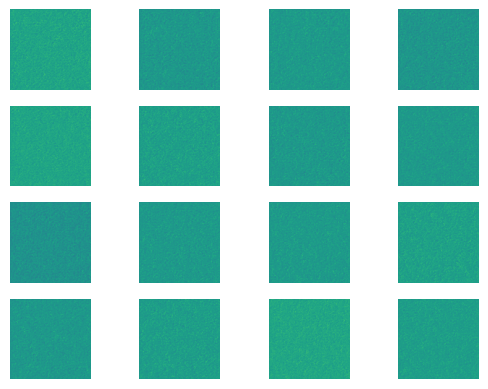

time for epoch 1 is 66.48202562332153 sec


In [85]:
train(datatr, epochs)